<a href="https://colab.research.google.com/github/brycemcwilliams/research-papers/blob/master/plant_seedlings_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Plant Seedlings Classicication

### Data Description:

- You are provided with a training set and a test set of images of plant seedlings at various stages of grown. 
- Each image has a filename that is its unique id. 
- The dataset comprises 12 plant species.
- The goal of the competition is to create a classifier capable of determining a plant's species from a photo.

### Dataset:
- The project is from a dataset from Kaggle.
- Link to the Kaggle project site:https://www.kaggle.com/c/plant-seedlings-classification/data
- The dataset has to be downloaded from the above Kagglewebsite.

### Context:

- Can you differentiate a weed from a crop seedling?
- The ability to do so effectively can mean better crop yields and better stewardship of the environment.
- The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently released a dataset containing images of unique plants belonging to 12 species at several growth stages.

### Objective:
- To implement the techniques learnt as a part of the course.

### Learning Outcomes:
- Pre-processing of image data.
- Visualization of images.
- Building CNN.
- Evaluate the Model.

In [2]:
# Import necessary libraries.
import sys
import cv2
import math
import numpy as np
import pandas as pd
import seaborn as sns

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from glob import glob
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.0.0


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set the path to the dataset folder. (The dataset contains image folder: "train")
train_path = "/content/drive/My Drive/Colab Notebooks/data/plant-seedlings-classification.zip"

In [4]:
# Make different folders for train and test data in the current directory of Google Colab notebook. (using mkdir)
!mkdir temp_train
!ls -la ./drive/My\ Drive/Colab\ Notebooks/data/

mkdir: cannot create directory ‘temp_train’: File exists
total 2414433
-rw------- 1 root root     684858 Jun  8 19:57 bank.csv
-rw------- 1 root root        151 Jun 12 18:47 bank.gsheet
-rw------- 1 root root     104187 Jun 25 18:30 brycemcwilliams.png
-rw------- 1 root root      18893 May 31 16:52 car-mpg.csv
-rw------- 1 root root  150828752 Sep 19  2019 creditcard.csv
-rw------- 1 root root   18322267 Jun 21 16:56 dataset_week_1.csv
-rw------- 1 root root 1810679877 Jun 29 16:51 plant-seedlings-classification.zip
-rw------- 1 root root  491644096 May 29 17:41 SVHN_single_grey1.h5
-rw------- 1 root root      88235 Jun 17 19:18 test_image.png
-rw------- 1 root root       4732 May 31 16:38 usedcars.csv


# Unziping train file:

In [5]:
# Extract the files from dataset to temp_train and temp_test folders (as the dataset is a zip file.)
from zipfile import ZipFile

with ZipFile(train_path, 'r') as zip:
  zip.extractall('./temp_train')

# Here we are getting all our training images and labels into arrays so that we can use them:

In [3]:
path = "./temp_train/train/*/*.png"                              # The path to all images in training set. (* means include all folders and files.)
files = glob(path)

trainImg = []                                              # Initialize empty list to store the image data as numbers.
trainLabel = []                                            # Initialize empty list to store the labels of images
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    '''
    Append the image data to trainImg list.
    Append the labels to trainLabel list.
    '''
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (128, 128)))  # Get image (with resizing to 128x128)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name contains the class to which the image belong)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

In [4]:
print(trainImg.shape)
print(trainLabel.shape)

(4750, 128, 128, 3)
(4750, 1)


# We can see from the above commands that we have 4750 images of 128x128x3 and their corresponding class labels for classification. We will need some kind of mapping for the class labels to make our lives eaiser in the future.

In [5]:
def classes_to_int(label):
    if label == "Black-grass":  return 0
    if label == "Charlock":  return 1
    if label == "Cleavers":  return 2
    if label == "Common Chickweed":  return 3
    if label == "Common wheat":  return 4
    if label == "Fat Hen":  return 5
    if label == "Loose Silky-bent": return 6
    if label == "Maize":  return 7
    if label == "Scentless Mayweed": return 8
    if label == "Shepherds Purse": return 9
    if label == "Small-flowered Cranesbill": return 10
    if label == "Sugar beet": return 11
    print("Invalid Label", label)
    return 12

In [6]:
def int_to_classes(i):
    if i == 0: return "Black-grass"
    elif i == 1: return "Charlock"
    elif i == 2: return "Cleavers"
    elif i == 3: return "Common Chickweed"
    elif i == 4: return "Common wheat"
    elif i == 5: return "Fat Hen"
    elif i == 6: return "Loose Silky-bent"
    elif i == 7: return "Maize"
    elif i == 8: return "Scentless Mayweed"
    elif i == 9: return "Shepherds Purse"
    elif i == 10: return "Small-flowered Cranesbill"
    elif i == 11: return "Sugar beet"
    print("Invalid class ", i)
    return "Invalid Class"

# Now that we have our class mappings we need to define our independant variables or X and our dependant variable or Y

In [7]:
X = np.array(trainImg, dtype="float") / 255.0
pd.DataFrame(X[0][0]).head()

,0,1,2
0,0.137255,0.203922,0.305882
1,0.141176,0.192157,0.298039
2,0.121569,0.176471,0.270588
3,0.168627,0.227451,0.305882
4,0.219608,0.270588,0.349020


In [8]:
Y = np.array(to_categorical(trainLabel[0].apply(lambda x: classes_to_int(x)), num_classes=12), dtype="float")
pd.DataFrame(Y).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# We need to define our global variables since we know that there are certain constraints we can enforce from understanding the training data

In [9]:
RANDOM_STATE = 42
NUM_CLASSES = 12
WIDTH = 128
HEIGHT = 128
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)
EPOCHS = 15
LEARNING_RATE = 0.001
BATCH_SIZE = 32
DECAY = LEARNING_RATE / EPOCHS
MIN_DELTA = 0.001
PATIENCE = 10

# CNN
Here we build our Convolutional Neural Network:

In [10]:
def create_model():
    model = Sequential()

    model.add(Conv2D(32, (3,3), padding="same", input_shape=INPUT_SHAPE))
    #model.add(BatchNormalization()) 
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    #model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    #model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(units=500))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(units=12))
    model.add(Activation("softmax"))

    optimizer = Adam(lr=LEARNING_RATE, decay=DECAY)

    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model.summary()

    return model

## Split our data into training and validation set

In [11]:
(x_train, x_validation, y_train, y_validation) = train_test_split(X, Y, test_size=0.25, random_state=RANDOM_STATE)

In [12]:
print(x_train.shape)
print(x_validation.shape)
print(y_train.shape)
print(y_validation.shape)

(3562, 128, 128, 3)
(1188, 128, 128, 3)
(3562, 12)
(1188, 12)


## Create an image data generator to handle input data normalization

In [13]:
imageDataGenerator = ImageDataGenerator(rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode="nearest")


## Build the model

In [14]:
model = create_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

## Implement early stopping

In [15]:
# Adding Early stopping callback to the fit function is going to stop the training,
# if the val_loss is not going to change even '0.001' for more than 10 continous epochs

early_stopping = EarlyStopping(monitor='val_loss', min_delta=MIN_DELTA, patience=PATIENCE)

## Add a model checkpoint to save on

In [16]:
# Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
# Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('seedling_cnn_checkpoint_{epoch:02d}_loss_{val_loss:.4f}.h5',
                                    monitor='val_loss',
                                    verbose=1,
                                    save_best_only=True,
                                    save_weights_only=True,
                                    mode='auto',
                                    period=1)


## Capture the history of the models training

In [17]:
history = model.fit(imageDataGenerator.flow(x_train,
                                          y_train,
                                          batch_size=BATCH_SIZE),
              validation_data=(x_validation, y_validation),
              steps_per_epoch=len(x_train) // BATCH_SIZE,
              epochs=EPOCHS,
              verbose=1,
              callbacks=[early_stopping, model_checkpoint])

Train for 111 steps, validate on 1188 samples
Epoch 1/15
110/111 [============================>.] - ETA: 1s - loss: 2.4822 - accuracy: 0.1432
Epoch 00001: val_loss improved from inf to 2.42157, saving model to seedling_cnn_checkpoint_01_loss_2.4216.h5
111/111 [==============================] - 168s 2s/step - loss: 2.4829 - accuracy: 0.1425 - val_loss: 2.4216 - val_accuracy: 0.1448
Epoch 2/15
110/111 [============================>.] - ETA: 1s - loss: 2.2690 - accuracy: 0.2161
Epoch 00002: val_loss improved from 2.42157 to 1.85682, saving model to seedling_cnn_checkpoint_02_loss_1.8568.h5
111/111 [==============================] - 166s 1s/step - loss: 2.2662 - accuracy: 0.2178 - val_loss: 1.8568 - val_accuracy: 0.4082
Epoch 3/15
110/111 [============================>.] - ETA: 1s - loss: 1.6835 - accuracy: 0.4214
Epoch 00003: val_loss improved from 1.85682 to 1.36690, saving model to seedling_cnn_checkpoint_03_loss_1.3669.h5
111/111 [==============================] - 176s 2s/step - loss: 

## Plot training history

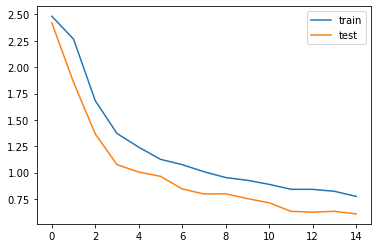

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Save our shiny new model

In [21]:
#model.save("plant-seedlings-model.h5")

## Evaluating our model

In [44]:
# Score trained model.
scores = model.evaluate(x_validation, y_validation, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

1188/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [45]:
y_predict = model.predict(x_validation)
y_predict = (y_predict > 0.5) # Force a prediction
y_predict

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       ...,
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False]])

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

In [47]:
cm = confusion_matrix(pd.DataFrame(y_validation).values.argmax(axis=1), pd.DataFrame(y_predict).values.argmax(axis=1))
print(cm)

[[ 32   0   0   0   2   1  25   0   0   0   0   1]
 [  2  91   6   0   0   0   0   0   0   0   0   0]
 [  7   4  65   1   0   0   0   0   1   0   0   0]
 [ 12   0   0 119   0   0   0   0   3   1   3   1]
 [ 15   0   0   0  32   1   1   0   0   0   0   0]
 [ 14   1   5   1   0  94   0   0   1   0   0   4]
 [ 41   0   0   1   0   0 128   0   1   0   1   0]
 [  7   3   0   1   0   0   0  37   2   0   0   2]
 [ 22   3   3   3   0   0   0   0  89   2   1   5]
 [ 25   1   0   0   0   1   0   2   8  27   1   1]
 [  8   2   2   0   0   0   0   1   1   0 116   7]
 [ 10   1   3   1   0   0   0   1   0   0   0  71]]


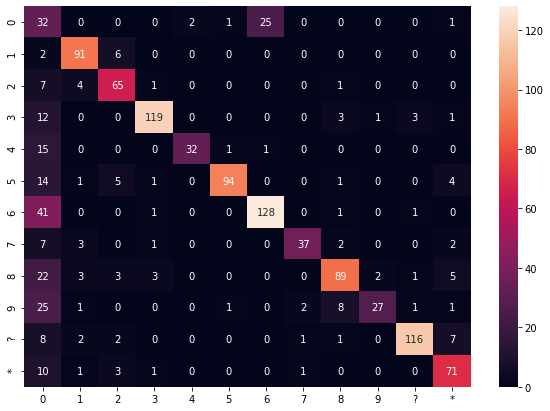

In [48]:
df_cm = pd.DataFrame(cm, index = [i for i in "0123456789?*"],
                     columns = [i for i in "0123456789?*"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d')

## We can see that our model has a problem identifying black-grass

In [49]:
print(classification_report(pd.DataFrame(y_validation).values.argmax(axis=1), pd.DataFrame(y_predict).values.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.16      0.52      0.25        61
           1       0.86      0.92      0.89        99
           2       0.77      0.83      0.80        78
           3       0.94      0.86      0.89       139
           4       0.94      0.65      0.77        49
           5       0.97      0.78      0.87       120
           6       0.83      0.74      0.79       172
           7       0.90      0.71      0.80        52
           8       0.84      0.70      0.76       128
           9       0.90      0.41      0.56        66
          10       0.95      0.85      0.90       137
          11       0.77      0.82      0.79        87

    accuracy                           0.76      1188
   macro avg       0.82      0.73      0.76      1188
weighted avg       0.84      0.76      0.79      1188



## We can observe that the network did not learn to identify the features of Black-grass correctly, we need to investigate as to why this is occuring

In [50]:
img_4095 = cv2.resize(trainImg[4095], (256,256), interpolation = cv2.INTER_AREA)
img_4749 = cv2.resize(trainImg[4749], (256,256), interpolation = cv2.INTER_AREA)

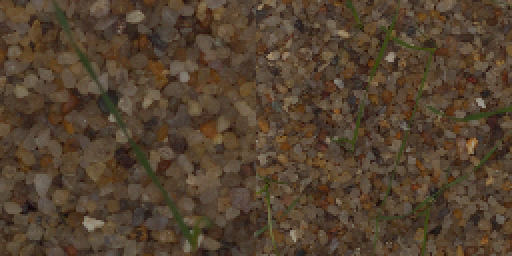

Black-grass vs Loose Silky-bent


In [51]:
h_img = cv2.hconcat([img_4095, img_4749])

cv2_imshow(h_img)
print("Black-grass vs Loose Silky-bent")

## We can observe that the two classes have visually similar features and are hard to distingush even for humans. We should put more weighting on getting this class wrong in our next model iteration.

In [52]:
img_4095_sobel = cv2.resize(cv2.Sobel(trainImg[4095], cv2.CV_64F, 1, 1, ksize=5), (256,256), interpolation = cv2.INTER_AREA)
img_4749_sobel = cv2.resize(cv2.Sobel(trainImg[4749], cv2.CV_64F, 1, 1, ksize=5), (256,256), interpolation = cv2.INTER_AREA)

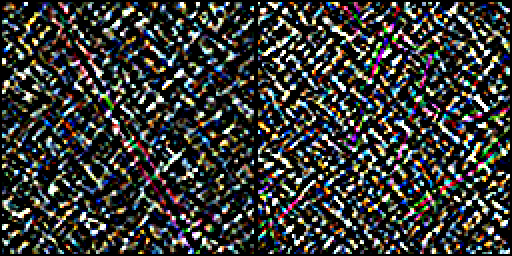

Black-grass Sobel vs Loose Silky-bent Sobel


In [53]:
h_img_sobel = cv2.hconcat([img_4095_sobel, img_4749_sobel])

cv2_imshow(h_img_sobel)
print("Black-grass Sobel vs Loose Silky-bent Sobel")

## We can observe that the features now present to us by applying the sobel filter are showing us that they are actually very similar visually as well.